# Rhetorical Analysis

This notebook documents the **Rhetorical Strategy analysis pipeline** for the BSc thesis:  
`Debates, Media, and Discourse: A Computational Analysis of Temporal Shifts in U.S. Presidential Debates and Media Framing Across the Political Spectrum`, written by **Emma Cristina Mora** (emma.mora@studbocconi.it) at **Bocconi University** under the supervision of **Professor Carlo Rasmus Schwarz**.  

The goal of this stage is to classify U.S. presidential debate utterances according to **Benoit’s Functional Theory of Political Discourse**—distinguishing between *Attack*, *Acclaim*, and *Defense* strategies—and to analyze how these rhetorical strategies vary across parties and decades.  

**Dataset Preparation**  
- The input dataset is **debates_rhetoric.csv**, containing ~6,300 utterances with metadata (`debate_id`, `speaker`, `party`, `year`, `decade`).  
- Rhetorical labels were assigned through a **few-shot GPT-based annotation pipeline**, trained on a manually labeled seed set.  
- Moderator utterances were excluded from analysis by resetting their rhetorical labels to `NaN`.  

**Exploratory Data Analysis (EDA)**  
- **Distributions by party**: quantifies how Democrats, Republicans, and Independents differ in their rhetorical emphasis.  
- **Distributions by decade**: tracks long-term trends in rhetorical strategy (1960s–2020s).  
- **Normalized proportions**: controls for differences in dataset size across groups.  
- **Temporal trends**: shows how the balance of *Attack*, *Acclaim*, and *Defense* shifts across election cycles.  

**Outputs**  
- Updated **debates_rhetoric.csv**, with moderator labels reset to `NaN`.  
- Visualizations and summary statistics of rhetorical strategies by party and decade.  

**Notebook Contribution**  
This pipeline provides the foundation for analyzing **rhetorical strategies in U.S. presidential debates**, enabling:  
- Comparison of partisan communication styles (*attack-oriented vs. acclaim-oriented*).  
- Longitudinal study of rhetorical trends across decades.  
- Integration with framing, sentiment, and ideological drift analyses in subsequent stages.  

## 1. Introduction and Config

In [3]:
# === LIBRARIES ===

from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import tqdm
import json

In [16]:
# === FILE PATHS ===

# set base repository path (assumes notebook is in repo/notebooks/)
REPO_DIR = Path(".").resolve().parents[0]

# key data paths
DATA_DIR = REPO_DIR / "data" 
DEBATES_DF_PATH = DATA_DIR / "rhetoric" / "debates_rhetoric.csv" 

# confirm setup
print("Repository Path:", REPO_DIR)
print("Data Directory:", DATA_DIR)
print("Debates Dataset:", DEBATES_DF_PATH)

# color palette
with open(Path(REPO_DIR / "color_palette_config.json")) as f:
    palette = json.load(f)

Repository Path: /Users/emmamora/Documents/GitHub/thesis
Data Directory: /Users/emmamora/Documents/GitHub/thesis/data
Debates Dataset: /Users/emmamora/Documents/GitHub/thesis/data/rhetoric/debates_rhetoric.csv


## 2. Load Data

In [6]:
# === LOAD DATA ===

debates_rhetoric = pd.read_csv(DEBATES_DF_PATH)

# basic sanity checks
print(debates_rhetoric.shape)
print(debates_rhetoric.columns)
debates_rhetoric.head(10)

(6316, 6)
Index(['utterance_id', 'debate_id', 'speaker', 'party', 'text',
       'rhetoric_label'],
      dtype='object')


,utterance_id,debate_id,speaker,party,text,rhetoric_label
0,1960_1_Presidential_Nixon_Kennedy_001,1960_1_Presidential_Nixon_Kennedy,Moderator,NaN,good evening. the television and radio station...,acclaim
1,1960_1_Presidential_Nixon_Kennedy_002,1960_1_Presidential_Nixon_Kennedy,Kennedy,Democrat,"mr. smith, mr. nixon. in the election of 1860,...",acclaim
2,1960_1_Presidential_Nixon_Kennedy_004,1960_1_Presidential_Nixon_Kennedy,Nixon,Republican,"mr. smith, senator kennedy. the things that se...",defense
3,1960_1_Presidential_Nixon_Kennedy_005,1960_1_Presidential_Nixon_Kennedy,Moderator,NaN,"thank you, mr. nixon. that completes the openi...",defense
4,1960_1_Presidential_Nixon_Kennedy_006,1960_1_Presidential_Nixon_Kennedy,Moderator,NaN,"senator, the vice president in his campaign ha...",defense
5,1960_1_Presidential_Nixon_Kennedy_007,1960_1_Presidential_Nixon_Kennedy,Kennedy,Democrat,"well, the vice president and i came to the con...",acclaim
6,1960_1_Presidential_Nixon_Kennedy_011,1960_1_Presidential_Nixon_Kennedy,Moderator,NaN,"mr. vice president, your campaign stresses the...",defense
7,1960_1_Presidential_Nixon_Kennedy_012,1960_1_Presidential_Nixon_Kennedy,Nixon,Republican,it would be rather difficult to cover them in ...,acclaim
8,1960_1_Presidential_Nixon_Kennedy_013,1960_1_Presidential_Nixon_Kennedy,Kennedy,Democrat,"well, i would say in the latter that the - and...",defense
9,1960_1_Presidential_Nixon_Kennedy_015,1960_1_Presidential_Nixon_Kennedy,Moderator,NaN,"uh - senator kennedy, during your brief speech...",defense


## 3. Checks and Drop Moderator

In [7]:
# === RESET MODERATOR LABELS TO NaN ===

before = debates_rhetoric["rhetoric_label"].value_counts(dropna=False)

# replace rhetoric_label with NaN for moderators
debates_rhetoric.loc[debates_rhetoric["speaker"].str.lower() == "moderator", "rhetoric_label"] = np.nan

after = debates_rhetoric["rhetoric_label"].value_counts(dropna=False)

print("[INFO] Distribution before:")
print(before)
print("\n[INFO] Distribution after resetting moderators:")
print(after)

# quick check
debates_rhetoric.query("speaker.str.lower() == 'moderator'").head()

[INFO] Distribution before:
rhetoric_label
defense        2400
attack         2231
acclaim        1675
unspecified      10
Name: count, dtype: int64

[INFO] Distribution after resetting moderators:
rhetoric_label
attack         1733
NaN            1552
defense        1545
acclaim        1477
unspecified       9
Name: count, dtype: int64


,utterance_id,debate_id,speaker,party,text,rhetoric_label
0,1960_1_Presidential_Nixon_Kennedy_001,1960_1_Presidential_Nixon_Kennedy,Moderator,NaN,good evening. the television and radio station...,NaN
3,1960_1_Presidential_Nixon_Kennedy_005,1960_1_Presidential_Nixon_Kennedy,Moderator,NaN,"thank you, mr. nixon. that completes the openi...",NaN
4,1960_1_Presidential_Nixon_Kennedy_006,1960_1_Presidential_Nixon_Kennedy,Moderator,NaN,"senator, the vice president in his campaign ha...",NaN
6,1960_1_Presidential_Nixon_Kennedy_011,1960_1_Presidential_Nixon_Kennedy,Moderator,NaN,"mr. vice president, your campaign stresses the...",NaN
9,1960_1_Presidential_Nixon_Kennedy_015,1960_1_Presidential_Nixon_Kennedy,Moderator,NaN,"uh - senator kennedy, during your brief speech...",NaN


## 4. Exploratory Data Analysis

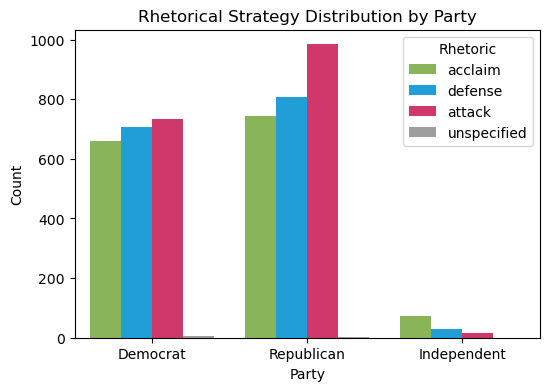

In [17]:
# === DISTRIBUTION BY PARTY ===

plt.figure(figsize=(6,4))
sns.countplot(
    data=debates_rhetoric,
    x="party",
    hue="rhetoric_label",
    palette=palette["rhetoric"]
)
plt.title("Rhetorical Strategy Distribution by Party")
plt.xlabel("Party")
plt.ylabel("Count")
plt.legend(title="Rhetoric")
plt.show()

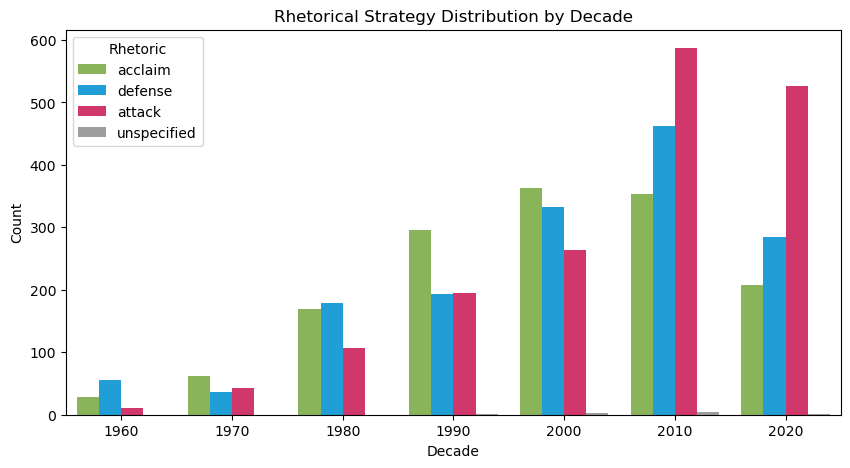

In [19]:
# === DISTRIBUTION BY DECADE ===

# extract year and decade from debate_id
debates_rhetoric["year"] = debates_rhetoric["debate_id"].str.extract(r"^(\d{4})").astype(float)
debates_rhetoric["decade"] = (debates_rhetoric["year"] // 10 * 10).astype("Int64")

plt.figure(figsize=(10,5))
sns.countplot(
    data=debates_rhetoric,
    x="decade",
    hue="rhetoric_label",
    palette=palette["rhetoric"]
)
plt.title("Rhetorical Strategy Distribution by Decade")
plt.xlabel("Decade")
plt.ylabel("Count")
plt.legend(title="Rhetoric")
plt.show()

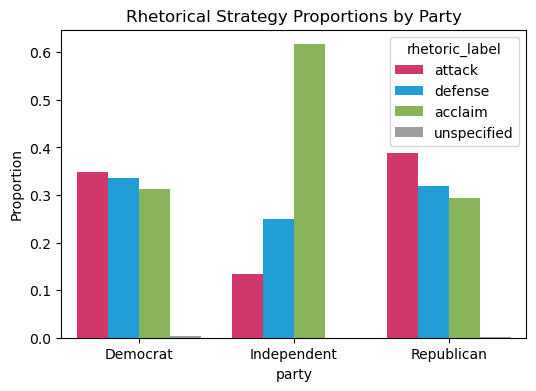

In [21]:
# === NORMALIZED DISTRIBUTIONS ===

# party-normalized proportions
party_props = (
    debates_rhetoric.groupby("party")["rhetoric_label"]
    .value_counts(normalize=True)
    .rename("proportion")
    .reset_index()
)

plt.figure(figsize=(6,4))
sns.barplot(
    data=party_props,
    x="party",
    y="proportion",
    hue="rhetoric_label",
    palette=palette["rhetoric"]
)
plt.title("Rhetorical Strategy Proportions by Party")
plt.ylabel("Proportion")
plt.show()

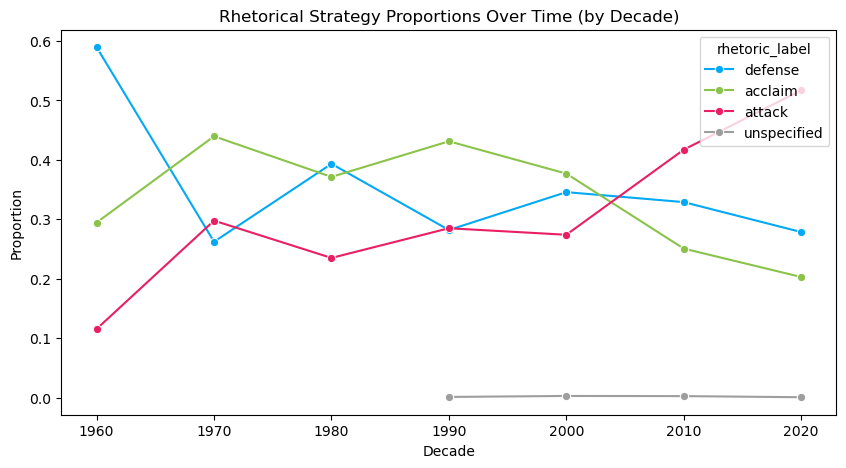

In [22]:
# === TREND OVER TIME (BY DECADE) ===

decade_props = (
    debates_rhetoric.groupby("decade")["rhetoric_label"]
    .value_counts(normalize=True)
    .rename("proportion")
    .reset_index()
)

plt.figure(figsize=(10,5))
sns.lineplot(
    data=decade_props,
    x="decade",
    y="proportion",
    hue="rhetoric_label",
    marker="o",
    palette=palette["rhetoric"]
)
plt.title("Rhetorical Strategy Proportions Over Time (by Decade)")
plt.ylabel("Proportion")
plt.xlabel("Decade")
plt.show()

## 5. Export

In [23]:
# === SAVE PROCESSED DATA ===

# overwrite the existing file with updated data (modified Moderator labels)
OUTPUT_PATH = DATA_DIR / "rhetoric" / "debates_rhetoric.csv"
debates_rhetoric.to_csv(OUTPUT_PATH, index=False)
print(f"[INFO] Processed data saved to: {OUTPUT_PATH}")

[INFO] Processed data saved to: /Users/emmamora/Documents/GitHub/thesis/data/rhetoric/debates_rhetoric.csv
